DeepChem provides a platform for researchers working with PROTACs datasets, offering tools like graph convolutional networks and molecular featurization to analyze and predict key properties of these molecules.

In this tutorial, we focus on using DeepChem to predict the Topological Polar Surface Area (TPSA) of molecules from their SMILES strings.

TPSA is a crucial molecular property, informing on a compound's absorption and distribution characteristics, which are vital for drug design.



Part 0. Introduction and limitation

PROTAC stands for PROteolysis TArgeting Chimeras. These are a relatively new class of therapeutic agents that are designed not just to inhibit but to actually induce the degradation of target proteins within cells.

Instead of merely blocking the activity of a disease-related protein, PROTACs recruit an E3 ubiquitin ligase to the target protein, leading to the protein’s ubiquitination and subsequent degradation by the proteasome. This mechanism allows for the removal of specific proteins from a cell and offers a precise approach that traditional small-molecule inhibitors or biologics might not achieve.

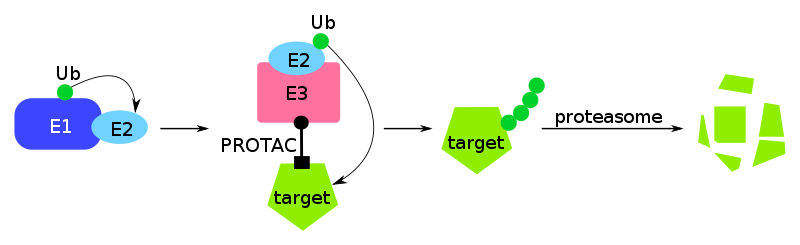

(Fig 1. Mechanism of action. E1, E2, E3 stand for ubiquitination enzymes; Ub stands for ubiquitin; target is the protein to be degraded [1](doi:10.1021/acschembio.7b00969))

PROTACs can be given in smaller doses relative to their inhibitor counterparts. They often exhibit greater selectivity than these inhibitors, which minimizes unintended interactions with other proteins.

PROTACs also have the capability to engage proteins that were once considered challenging to drugs, as they don't rely on binding to active sites. This characteristic also aids in circumventing the issue of drug resistance that frequently arises due to mutations in enzyme targets.

 However, PROTACs are complex molecules that require sophisticated modeling and simulation techniques to understand their behavior and interactions with biological targets.
Given DeepChem's focus on molecular machine learning, challenges could potentially include: Accurately modeling the dynamic interactions between PROTACs and their protein targets; Dealing with the vast chemical space of bifunctional molecules, and integrating data from various sources to predict efficacy.

Let's start the tutorial:

1. Setup Environment


In [ ]:
pip install deepchem

Part 1: Setup and Data Preparation

Step 1: Data Preparation

  - Dataset File: The path to the CSV file containing the dataset. It should include at least two columns: one for the SMILES representation of molecules and another for the TPSA values.
  - Dataset used here as example: [Compound Group AAK1, KIAA1048](http://cadd.zju.edu.cn/protacdb/downloads)
  - Feature and Activity Fields: Identifies the columns in the dataset that contain the features ('Smiles') and the target variable ('Topological Polar Surface Area') for the prediction task.

In [ ]:
import deepchem as dc
import numpy as np

dataset_file = '/content/AAK1.csv'  # Update with the correct path
feature_field = "Smiles"
activity_field = "Topological Polar Surface Area"
tasks = [activity_field]

Step 2: Featurization

  - Featurizer: Converts the SMILES strings into a machine-usable format. The ConvMolFeaturizer is used here, which is suitable for graph-based models.

In [ ]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field=feature_field, featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

Step 3: Dataset Splitting

  - Splitter: Divides the dataset into training, validation, and test sets. The RandomSplitter is used for a random split which is crucial for evaluating the model's performance on unseen data.

In [ ]:
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

Part 2: Model Building, Training, and Evaluation

Step 4: Model Building

  - Graph Convolutional Model: A type of neural network that directly works on graphs of molecules. It's initialized here for regression tasks, targeting the prediction of TPSA.

In [ ]:
model = dc.models.GraphConvModel(n_tasks=len(tasks), mode='regression')

Step 5: Training

  - Model Training: The model is trained on the training dataset for a specified number of epochs, allowing it to learn the relationship between the molecular features and TPSA values.

In [ ]:
model.fit(train_dataset, nb_epoch=50)

8644.46375

Step 6: Evaluation

  - Metric: Uses the Pearson R^2 score to evaluate the model's performance. This metric assesses the correlation between the predicted and actual TPSA values across the training, validation, and test datasets.

In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric]))
print("Validation set score:", model.evaluate(valid_dataset, [metric]))
print("Test set score:", model.evaluate(test_dataset, [metric]))

Training set score: {'pearson_r2_score': 0.025807516130339204}
Validation set score: {'pearson_r2_score': 1.0}
Test set score: {'pearson_r2_score': 0.8622170152840211}


Additional Evaluation

  - Variance in Predictions and Labels: Calculating the variance of the model's predictions and the actual labels helps in understanding the model's learning behavior and the diversity of the dataset.

In [ ]:
train_predictions = model.predict(train_dataset)
print("Variance in Train Predictions:", np.var(train_predictions, axis=0))
print("Variance in Train Labels:", np.var(train_dataset.y, axis=0))


Variance in Train Predictions: [0.916138]
Variance in Train Labels: [725.66365329]


Predictions

In [ ]:
#Step 7: Generate predictions
tpsas_predicted = model.predict_on_batch(test_dataset.X[:10])

#Step 8: Display their SMILES, predicted TPSA, and actual TPSA
for molecule, predicted_tpsa, actual_tpsa in zip(test_dataset.ids[:10], tpsas_predicted, test_dataset.y[:10]):
    print("Predicted TPSA:", predicted_tpsa[0], "Actual TPSA:", actual_tpsa[0], "SMILES:", molecule)


Predicted TPSA: 8.882188 Actual TPSA: 193.81 SMILES: CC1=C(C2=CC=C([C@H](C)NC(=O)[C@@H]3C[C@@H](O)CN3C(=O)[C@@H](NC(=O)CCCCCN3CCC4=CC(NC5=NC=C(C6CC6)C(NCCCNC(=O)C6CCC6)=N5)=CC=C4C3)C(C)(C)C)C=C2)SC=N1
Predicted TPSA: 9.355637 Actual TPSA: 220.02 SMILES: O=C(CCCCCCNC(=O)COC1=CC=CC2=C1C(=O)N(C1CCC(=O)NC1=O)C2=O)NCCOC1=CC=C(NC2=NC=C3C=CC(=O)N(C4CC5CCC4C5)C3=N2)C=C1
Predicted TPSA: 10.33756 Actual TPSA: 233.6 SMILES: CC(C)S(=O)(=O)C1=CC=CC=C1NC1=NC(NC2=CC=C(N3CCN(CCOCCOCCNC(=O)CNC4=CC=C5C(=O)N(C6CCC(=O)NC6=O)C(=O)C5=C4)CC3)C=C2)=NC=C1Cl


Reference

Ishoey, Mette; Chorn, Someth; Singh, Natesh; Jaeger, Martin G.; Brand, Matthias; Paulk, Joshiawa; Bauer, Sophie; Erb, Michael A.; Parapatics, Katja; Müller, André C.; Bennett, Keiryn L.; Ecker, Gerhard F.; Bradner, James E.; Winter, Georg E. (2018). "Translation Termination Factor GSPT1 is a Phenotypically Relevant Off-Target of Heterobifunctional Phthalimide Degraders". ACS Chemical Biology. 13 (3): 553–560. doi:10.1021/acschembio.7b00969